In [130]:
#Importing libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

from sklearn.metrics import (accuracy_score,
                             precision_score, 
                             f1_score,
                             recall_score,
                             classification_report,
                             confusion_matrix,
                             make_scorer,
                             silhouette_score)

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import xgboost as xgb
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout,Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, History, ModelCheckpoint

import optuna
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Defining Functions

def confusion_matrix_axis(test, prediction, x, title):
    sns.heatmap(confusion_matrix(test, prediction), annot = True, fmt = 'd', cmap = 'Blues', ax = x)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    x.set_title(title)
    
def confusion_matrix_array(test, prediction, x, y, title) :
    
    sns.heatmap(confusion_matrix(test, prediction), annot = True, fmt ='d', cmap = 'Blues', ax = axes[x, y])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    axes[x, y].set_title(title)

In [3]:
#Importing data

#Source data : https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023
#The source data has been stored locally - due to the size of the file, it will not be passed to the github repo

directory_path = 'C:/Datasets/Fraud Detection/'

df = pd.read_csv(f'{directory_path}creditcard_2023.csv')

df.shape #Almost 570k observations - let's randomly select 10% for the model

(568630, 31)

In [4]:
df.Class.value_counts() #Data perfectly balanced

0    284315
1    284315
Name: Class, dtype: int64

In [5]:
#Sampling a smaller dataframe

subset_0 = df.query('Class == 0').sample(frac = 0.1)
subset_1 = df.query('Class == 1').sample(frac = 0.1)

df = pd.concat([subset_0, subset_1], axis = 0).sample(frac = 1)

In [6]:
#Saving the sample in case of future experiments
#This sample file will be uploaded on a GitHub repo

df.to_csv('creditcard_2023_sample.csv', sep=',', index=False, encoding='utf-8')

In [7]:
#Reading back the saved sample data

df = pd.read_csv('creditcard_2023_sample.csv')

# 1. Exploratory Data Analysis

In [8]:
df.head()

id        V1        V2        V3        V4        V5        V6  \
0  103325  1.017017 -0.448034  0.055175 -0.585025  1.378517  2.175035   
1  263418  1.965833 -0.936438  0.234668 -1.452576 -0.236071 -0.190453   
2   40683 -0.142054 -0.179395  1.554632 -0.218356  0.056700  0.120837   
3  274590  1.374450 -0.575139  0.000045 -0.279653  0.078663 -0.580038   
4  281373 -0.291823 -0.189574  0.208370 -0.683384  0.340954 -0.085538   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.303148  0.034503  0.406518  0.646969 -0.728274  0.616706  0.084930   
1  0.129121 -0.202946 -0.294337  1.574583  0.007662  0.829328  0.680827   
2  0.416552 -0.040064  0.252017  0.396920 -1.262804  0.289131 -0.919494   
3  0.575540 -0.238810  1.090233  0.242427 -0.344269  1.324103  0.249382   
4  0.573720 -0.346289  0.620330  0.602583 -1.550539  0.821108  0.198181   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.994584  1.341851  0.801421  0.170843  0.591241 -0.311349 -0.116718   
1  0.584748 -1.055903  0.147944  0.606794  0.389007 -0.264987 -0.612842   
2  1.127200  1.806779  0.560524  0.418672  0.846912  0.004627 -0.192505   
3  0.098890 -0.222010  0.302635  1.100939  0.119306 -0.529157 -0.015921   
4  0.847958 -0.437626  0.335205  0.424334 -0.059396  0.311283 -1.337186   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.088916 -0.104501 -0.195855  2.242832  1.308657 -0.633067 -0.220801   
1 -0.133639  0.233552  0.267434  1.158599 -0.500239 -0.502704 -0.228251   
2  0.030495  0.652422 -0.200268  0.814567 -0.028176 -0.388763 -0.222435   
3 -0.137870 -0.335162  0.130289  1.662077 -0.470857 -0.361708 -0.270130   
4  0.101488 -0.441531  0.751059 -0.136796 -1.146405  0.499159 -0.640535   

        V28    Amount  Class  
0 -0.050265   1215.71      0  
1 -0.233078   7399.30      0  
2 -0.033513  21634.35      0  
3 -0.052150  14191.59      0  
4 -0.469814   4940.70      0

In [9]:
#Removing doubled index

#df = df.set_index('id')

#df.shape #Almost 57k observations

In [10]:
df.Class.value_counts() #Data perfectly balanced

0    28432
1    28432
Name: Class, dtype: int64

In [11]:
df.info() #Dataset does not have missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56864 entries, 0 to 56863
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      56864 non-null  int64  
 1   V1      56864 non-null  float64
 2   V2      56864 non-null  float64
 3   V3      56864 non-null  float64
 4   V4      56864 non-null  float64
 5   V5      56864 non-null  float64
 6   V6      56864 non-null  float64
 7   V7      56864 non-null  float64
 8   V8      56864 non-null  float64
 9   V9      56864 non-null  float64
 10  V10     56864 non-null  float64
 11  V11     56864 non-null  float64
 12  V12     56864 non-null  float64
 13  V13     56864 non-null  float64
 14  V14     56864 non-null  float64
 15  V15     56864 non-null  float64
 16  V16     56864 non-null  float64
 17  V17     56864 non-null  float64
 18  V18     56864 non-null  float64
 19  V19     56864 non-null  float64
 20  V20     56864 non-null  float64
 21  V21     56864 non-null  float64
 22

NOTE : Memory usage can be optimizes. Changing float64 to float32 will reduce it; also int64 is a waste of memory for binary variable.

NOTE : Make sure that changing data format will not affect the data significantly.

In [12]:
df.describe().transpose()

count           mean            std        min            25%  \
id      56864.0  284017.253974  164234.884326  10.000000  141315.500000   
V1      56864.0      -0.002936       0.998887  -2.908410      -0.567614   
V2      56864.0      -0.006061       1.028660 -30.224879      -0.487617   
V3      56864.0       0.003285       1.000755  -2.518308      -0.646798   
V4      56864.0       0.000260       1.001013  -4.951222      -0.650329   
V5      56864.0       0.004893       1.038323  -5.038171      -0.295233   
V6      56864.0       0.002157       1.011734 -18.642598      -0.439648   
V7      56864.0       0.002302       1.005689  -4.346706      -0.288868   
V8      56864.0      -0.003017       0.997175  -6.516688      -0.192498   
V9      56864.0      -0.000101       0.993304  -3.750630      -0.558531   
V10     56864.0       0.001943       0.990974  -3.161805      -0.585944   
V11     56864.0       0.001588       0.997346  -5.117655      -0.698385   
V12     56864.0       0.002953       0.999464  -2.017134      -0.826983   
V13     56864.0      -0.002180       1.002160  -3.811206      -0.707026   
V14     56864.0      -0.000362       0.994322  -2.107417      -0.867930   
V15     56864.0       0.010955       0.999147  -3.851599      -0.612871   
V16     56864.0       0.003410       0.999983  -2.211530      -0.716645   
V17     56864.0       0.004209       1.002363  -2.484682      -0.616162   
V18     56864.0       0.003820       1.000922  -2.411786      -0.554368   
V19     56864.0       0.004920       1.000098  -3.850153      -0.561656   
V20     56864.0      -0.004528       1.022061 -37.716673      -0.349575   
V21     56864.0       0.005744       0.989934 -12.132225      -0.166657   
V22     56864.0      -0.001751       0.993306  -6.450353      -0.492051   
V23     56864.0       0.002254       1.030084 -14.244888      -0.235016   
V24     56864.0      -0.001470       1.003248  -3.952723      -0.653285   
V25     56864.0      -0.005877       1.003064  -6.688980      -0.557881   
V26     56864.0       0.004984       0.997178  -4.989112      -0.629038   
V27     56864.0       0.007048       0.998238  -5.672326      -0.303137   
V28     56864.0       0.000155       0.993959 -21.733407      -0.231552   
Amount  56864.0   12020.647539    6905.789947  50.550000    6048.472500   
Class   56864.0       0.500000       0.500004   0.000000       0.000000   

                  50%            75%            max  
id      284385.000000  426228.000000  568626.000000  
V1          -0.098259       0.829770       2.219470  
V2          -0.134566       0.342287       4.355977  
V3           0.003809       0.632338       4.340475  
V4          -0.073408       0.700375       2.576901  
V5           0.081385       0.438560      41.540257  
V6           0.081124       0.499269      10.199833  
V7           0.231837       0.526165      53.501637  
V8          -0.115500       0.047143       5.958040  
V9           0.096547       0.554395      12.171681  
V10          0.262934       0.592891      12.954246  
V11         -0.035647       0.746315       2.513573  
V12          0.167134       0.744346       7.175420  
V13          0.018759       0.686802       4.406310  
V14          0.232143       0.750995       7.914221  
V15         -0.035124       0.676871       8.533068  
V16          0.137444       0.661015      15.104540  
V17          0.273050       0.521820       5.228980  
V18          0.088813       0.549186       4.693601  
V19         -0.018539       0.568707       3.568718  
V20         -0.122881       0.251390      20.610088  
V21         -0.037627       0.151595       8.087080  
V22         -0.025317       0.469919       9.767979  
V23         -0.058404       0.159584      31.004622  
V24          0.015858       0.701812      10.808906  
V25         -0.010428       0.544390      11.558177  
V26         -0.014314       0.679302       5.163583  
V27         -0.171450       0.332125      22.915024  
V28         -0.012479       0.408968      3

In [13]:
print('Class 0')
df.query('Class == 0').describe().transpose()

Class 0


count           mean           std        min           25%  \
id      28432.0  142080.439540  82217.794240  10.000000  70764.250000   
V1      28432.0       0.501664      0.823555  -2.908410     -0.140771   
V2      28432.0      -0.499004      0.774270 -30.224879     -0.661521   
V3      28432.0       0.685150      0.703208  -2.222259      0.152516   
V4      28432.0      -0.734854      0.673238  -4.951222     -1.085372   
V5      28432.0       0.344408      0.762049  -5.038171      0.015984   
V6      28432.0       0.436090      0.757130 -18.642598      0.017277   
V7      28432.0       0.495075      0.702595  -3.038728      0.258315   
V8      28432.0      -0.145850      0.234925  -4.487491     -0.198821   
V9      28432.0       0.579484      0.726754  -1.313303      0.146166   
V10     28432.0       0.672804      0.623485  -1.576567      0.393997   
V11     28432.0      -0.718120      0.641410  -5.117655     -1.145300   
V12     28432.0       0.772014      0.587223  -1.697570      0.395153   
V13     28432.0       0.070136      1.017001  -3.811206     -0.597620   
V14     28432.0       0.801742      0.525594  -1.485458      0.499365   
V15     28432.0       0.046432      1.010182  -3.441835     -0.645552   
V16     28432.0       0.575254      0.549416  -1.670433      0.216446   
V17     28432.0       0.477368      0.284815  -1.729068      0.296775   
V18     28432.0       0.411370      0.583950  -1.494881      0.029817   
V19     28432.0      -0.237805      0.702012  -3.829759     -0.617497   
V20     28432.0      -0.185137      0.879006 -37.716673     -0.380930   
V21     28432.0      -0.109182      0.279977  -5.696745     -0.195294   
V22     28432.0      -0.010474      0.666042  -6.192213     -0.520802   
V23     28432.0      -0.008220      0.687043 -13.895872     -0.183850   
V24     28432.0       0.127933      1.134370  -3.952723     -0.603036   
V25     28432.0      -0.065367      0.847818  -6.506163     -0.592665   
V26     28432.0      -0.060499      1.078107  -4.989112     -0.765989   
V27     28432.0      -0.204995      0.520600  -5.672326     -0.316084   
V28     28432.0      -0.101822      0.763956 -21.733407     -0.226086   
Amount  28432.0   12039.139657   6930.263320  50.640000   6015.177500   
Class   28432.0       0.000000      0.000000   0.000000      0.000000   

                  50%            75%            max  
id      141662.500000  212979.500000  284806.000000  
V1           0.207784       1.086673       2.219470  
V2          -0.424223      -0.188482       2.113965  
V3           0.569314       1.109343       4.340475  
V4          -0.632115      -0.310884       2.576901  
V5           0.231469       0.516040      41.540257  
V6           0.321631       0.706683      10.199833  
V7           0.446144       0.646832      53.501637  
V8          -0.147047      -0.076953       3.142211  
V9           0.458658       0.885237      12.171681  
V10          0.560011       0.812542      12.954246  
V11         -0.625882      -0.214410       1.974999  
V12          0.713618       1.112751       7.175420  
V13          0.065390       0.752501       4.406310  
V14          0.729110       1.006664       7.914221  
V15          0.013429       0.735598       8.533068  
V16          0.505693       0.842153      15.104540  
V17          0.420364       0.584943       5.228980  
V18          0.317293       0.685914       3.752373  
V19         -0.207250       0.175513       3.307834  
V20         -0.225171      -0.023044      20.610088  
V21         -0.114518      -0.029526       6.824706  
V22         -0.038006       0.461923       6.602707  
V23         -0.033593       0.128964      31.004622  
V24          0.113744       0.929248      10.808906  
V25         -0.059295       0.495895      11.558177  
V26         -0.100829       0.554545       5.163583  
V27         -0.234538      -0.126995      22.915024  
V28         -0.071327       0.094307      30.160983  
Amount   12065.440000   18066.407500   24039.480000  

In [14]:
print('Class 1')
df.query('Class == 1').describe().transpose()

Class 1


count           mean           std          min            25%  \
id      28432.0  425954.068409  83029.161849  6820.000000  355037.250000   
V1      28432.0      -0.507536      0.898933    -2.637662      -0.992487   
V2      28432.0       0.486882      1.015294    -4.301274      -0.061608   
V3      28432.0      -0.678579      0.760687    -2.518308      -1.058122   
V4      28432.0       0.735374      0.685578    -1.348452       0.218214   
V5      28432.0      -0.334621      1.159741    -3.301638      -0.891426   
V6      28432.0      -0.431776      1.047565    -3.944821      -1.048631   
V7      28432.0      -0.490471      1.021542    -4.346706      -0.995355   
V8      28432.0       0.139815      1.375775    -6.516688      -0.173921   
V9      28432.0      -0.579687      0.879379    -3.750630      -1.130140   
V10     28432.0      -0.668918      0.821717    -3.161805      -1.096887   
V11     28432.0       0.721297      0.736227    -2.002487       0.300914   
V12     28432.0      -0.766108      0.685645    -2.017134      -1.219592   
V13     28432.0      -0.074496      0.981801    -3.130623      -0.804091   
V14     28432.0      -0.802467      0.643700    -2.107417      -1.227706   
V15     28432.0      -0.024522      0.986732    -3.851599      -0.575596   
V16     28432.0      -0.568435      1.021799    -2.211530      -1.264151   
V17     28432.0      -0.468949      1.216802    -2.484682      -1.331385   
V18     28432.0      -0.403730      1.153482    -2.411786      -1.346787   
V19     28432.0       0.247645      1.178886    -3.850153      -0.424992   
V20     28432.0       0.176080      1.118643    -4.823031      -0.292960   
V21     28432.0       0.120670      1.362046   -12.132225      -0.057344   
V22     28432.0       0.006973      1.236764    -6.450353      -0.463182   
V23     28432.0       0.012728      1.284498   -14.244888      -0.311417   
V24     28432.0      -0.130874      0.832323    -3.046501      -0.691230   
V25     28432.0       0.053612      1.134211    -6.688980      -0.510350   
V26     28432.0       0.070468      0.904363    -3.134266      -0.521811   
V27     28432.0       0.219091      1.277514    -4.947034      -0.246592   
V28     28432.0       0.102132      1.171118    -4.572705      -0.261391   
Amount  28432.0   12002.155420   6881.301719    50.550000    6071.165000   
Class   28432.0       1.000000      0.000000     1.000000       1.000000   

                  50%            75%            max  
id      426234.000000  497289.500000  568626.000000  
V1          -0.470097       0.018946       1.873349  
V2           0.315115       0.855723       4.355977  
V3          -0.640789      -0.192829       2.193790  
V4           0.674695       1.219092       2.393860  
V5          -0.226462       0.287105       9.052156  
V6          -0.336241       0.209028       3.519433  
V7          -0.273415       0.153834       3.802076  
V8          -0.020829       0.256410       5.958040  
V9          -0.511658       0.023965       3.325877  
V10         -0.585096      -0.218250       3.384513  
V11          0.745854       1.184902       2.513573  
V12         -0.826830      -0.436557       1.894505  
V13         -0.048153       0.631000       2.907004  
V14         -0.867841      -0.524711       4.168294  
V15         -0.067529       0.621550       3.249914  
V16         -0.715226      -0.178429       3.992299  
V17         -0.615978      -0.002886       4.703885  
V18         -0.497232       0.279470       4.693601  
V19          0.330688       1.003249       3.568718  
V20          0.115277       0.612767       9.252387  
V21          0.125181       0.358642       8.087080  
V22         -0.012738       0.475860       9.767979  
V23         -0.088990       0.227424       6.528149  
V24         -0.119128       0.442305       2.399681  
V25          0.022575       0.597746       3.838035  
V26          0.050459       0.737199       4.496879  
V27          0.261729       0.743847       4.755680  
V28        

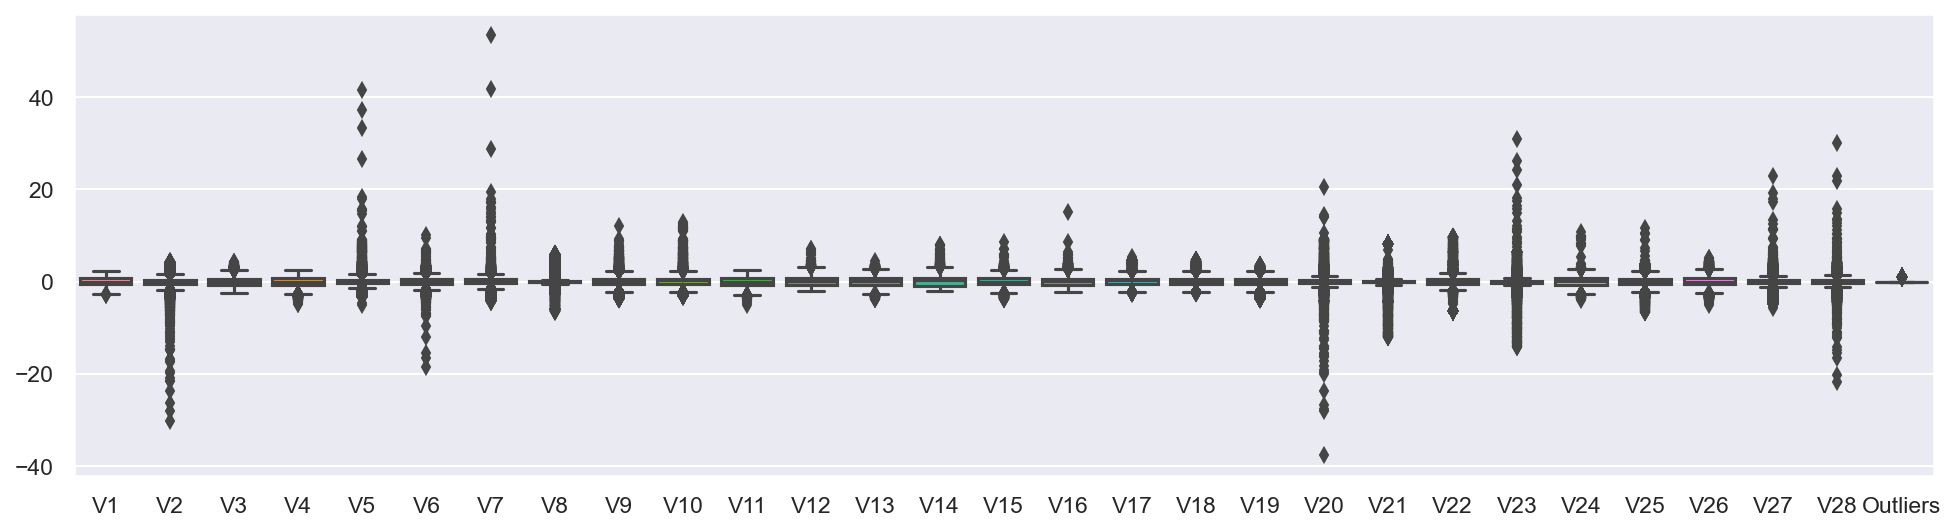

In [158]:
#First look at outliers

plt.figure(figsize = (16, 4), dpi = 150)
sns.boxplot(data = df.drop(columns = ['Class', 'Amount', 'id'], axis = 1))
plt.show();

NOTE : Some of the features have outliers, what should be corrected at the data preparation stage.

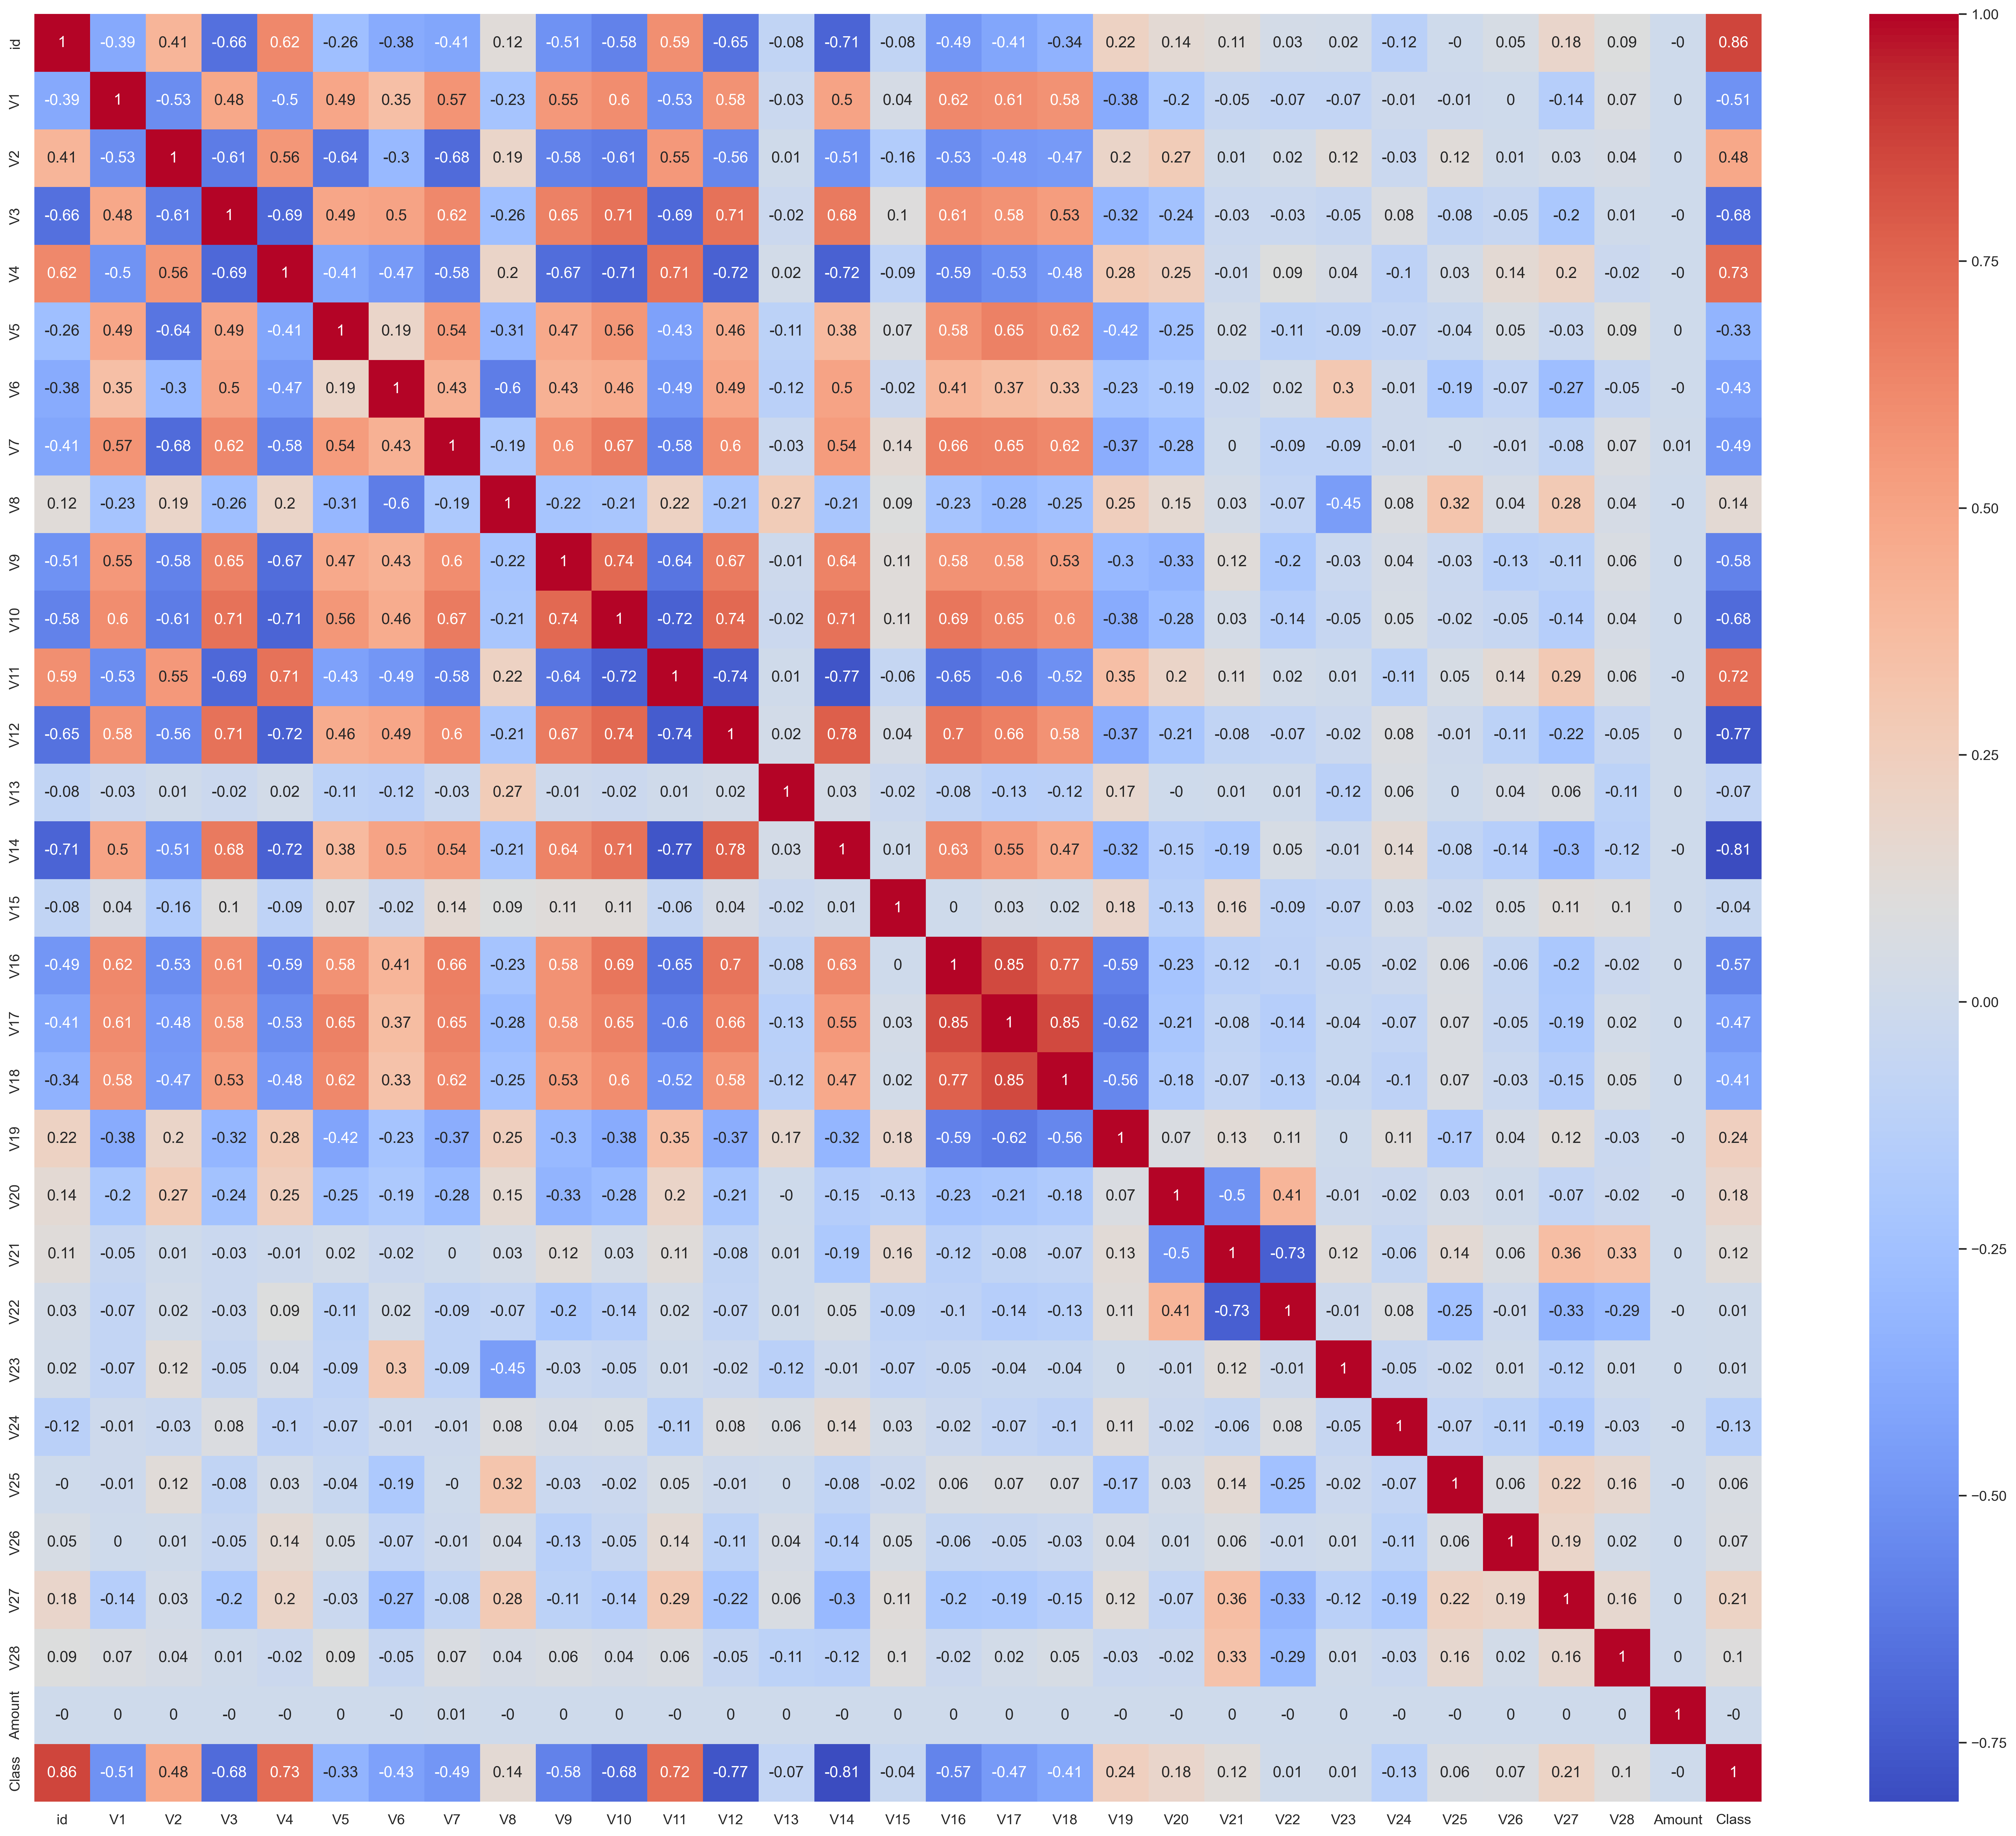

In [16]:
#Analyzing correlations

correlation_matrix = np.round(df.corr(method = 'pearson'), 2)

plt.figure(figsize = (30, 25), dpi = 300)
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm")
plt.show();

NOTE : After removing outliers, only features at least moderately correlated with target will remain for the modelling purposes. 

# 2. Data preparation

In [17]:
#Creating a dataset copy for the model.

data = pd.DataFrame(df)

In [18]:
#Identifying outliers

clf = IsolationForest(contamination = 0.05)
clf.fit(data)
outliers = clf.predict(data) == -1
outlier_data = data[outliers]

len(outlier_data)

2844

In [19]:
data['Outliers'] = outliers
data.query('Outliers == True').head() #Outliers successfully marked 

id        V1        V2        V3        V4        V5        V6  \
12   246232 -1.592436  1.804798 -0.927923 -1.431318 -1.206855  1.031732   
13   286693 -2.033423  2.407741 -1.952072  2.021713 -2.439719  0.019969   
25   357597 -2.497618  4.090279 -2.290114  2.282162 -2.781108  2.997519   
82   300467 -2.590931  3.280487 -2.477666  1.277290 -3.223228 -2.863648   
123  458119 -1.704517  2.599199 -1.205391  0.503527 -0.949674  3.226002   

           V7        V8        V9       V10       V11       V12       V13  \
12  -1.237944 -0.168960  0.386489  0.240421 -2.595436  6.523728  0.563349   
13  -2.759599 -0.856465 -2.569377 -2.242736  1.006502 -1.566024  0.203143   
25  -4.080793 -5.699546 -3.542457 -3.100942  0.762309 -1.365550 -2.936408   
82  -2.434642  5.723686 -1.064032 -1.174024  0.890116 -0.858758  1.413716   
123 -2.323095 -6.027712  0.273389 -0.698893  0.990274 -0.707780 -1.891977   

          V14       V15       V16       V17       V18       V19       V20  \
12   7.102341 -1.008493  2.999586  1.691739  1.298619 -0.297965 -3.354639   
13  -0.538927 -1.759791 -1.760210 -1.959493 -2.173723  1.477527  1.393606   
25   0.173286 -3.112222 -1.289850 -1.468056 -1.652368 -0.787086  8.010221   
82  -0.622542 -0.185111 -1.058470 -1.297381 -1.407724  0.311993  1.491245   
123 -1.183117 -0.287687 -1.230971 -0.722383 -0.990630 -0.169996 -4.118596   

           V21       V22       V23       V24       V25       V26       V27  \
12    2.686787 -2.718635  2.380547  0.007017  0.837155 -0.696018 -2.317166   
13   -1.850701  2.036268  1.614448  1.308488 -1.442465 -0.064082 -3.161965   
25  -10.367215  8.419508  5.120998  0.193734 -1.896758 -0.163259 -3.941171   
82    0.573645 -1.853157 -1.329066  0.381956  3.676644 -0.485723  1.535891   
123   8.087080 -6.450353  6.343132 -1.075048  0.349881 -0.240261  1.534445   

          V28    Amount  Class  Outliers  
12  -1.328210    622.52      0      True  
13  -2.188965   1734.67      1      True  
25  -0.796518  11237.93      1      True  
82   0.790582   8463.78      1      True  
123  2.154102   2614.92      1      True

In [20]:
#Removing outliers

data = data.query('Outliers == False').drop(columns = ['Outliers'], axis = 1)
data.head()

id        V1        V2        V3        V4        V5        V6  \
0  103325  1.017017 -0.448034  0.055175 -0.585025  1.378517  2.175035   
1  263418  1.965833 -0.936438  0.234668 -1.452576 -0.236071 -0.190453   
2   40683 -0.142054 -0.179395  1.554632 -0.218356  0.056700  0.120837   
3  274590  1.374450 -0.575139  0.000045 -0.279653  0.078663 -0.580038   
4  281373 -0.291823 -0.189574  0.208370 -0.683384  0.340954 -0.085538   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.303148  0.034503  0.406518  0.646969 -0.728274  0.616706  0.084930   
1  0.129121 -0.202946 -0.294337  1.574583  0.007662  0.829328  0.680827   
2  0.416552 -0.040064  0.252017  0.396920 -1.262804  0.289131 -0.919494   
3  0.575540 -0.238810  1.090233  0.242427 -0.344269  1.324103  0.249382   
4  0.573720 -0.346289  0.620330  0.602583 -1.550539  0.821108  0.198181   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.994584  1.341851  0.801421  0.170843  0.591241 -0.311349 -0.116718   
1  0.584748 -1.055903  0.147944  0.606794  0.389007 -0.264987 -0.612842   
2  1.127200  1.806779  0.560524  0.418672  0.846912  0.004627 -0.192505   
3  0.098890 -0.222010  0.302635  1.100939  0.119306 -0.529157 -0.015921   
4  0.847958 -0.437626  0.335205  0.424334 -0.059396  0.311283 -1.337186   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.088916 -0.104501 -0.195855  2.242832  1.308657 -0.633067 -0.220801   
1 -0.133639  0.233552  0.267434  1.158599 -0.500239 -0.502704 -0.228251   
2  0.030495  0.652422 -0.200268  0.814567 -0.028176 -0.388763 -0.222435   
3 -0.137870 -0.335162  0.130289  1.662077 -0.470857 -0.361708 -0.270130   
4  0.101488 -0.441531  0.751059 -0.136796 -1.146405  0.499159 -0.640535   

        V28    Amount  Class  
0 -0.050265   1215.71      0  
1 -0.233078   7399.30      0  
2 -0.033513  21634.35      0  
3 -0.052150  14191.59      0  
4 -0.469814   4940.70      0

In [21]:
#Removing features that are weakly correlated with target

cols = data.columns.tolist()
del cols[-1:] #last column contains target

for col in cols :
    
    if np.abs(data['Class'].corr(data[col])) < 0.3 : #Assuming correlations from range <-0,3;0,3> are weak and very weak
        data.drop(columns = [col], axis = 1, inplace = True)
        
data.head()

id        V1        V2        V3        V4        V5        V6  \
0  103325  1.017017 -0.448034  0.055175 -0.585025  1.378517  2.175035   
1  263418  1.965833 -0.936438  0.234668 -1.452576 -0.236071 -0.190453   
2   40683 -0.142054 -0.179395  1.554632 -0.218356  0.056700  0.120837   
3  274590  1.374450 -0.575139  0.000045 -0.279653  0.078663 -0.580038   
4  281373 -0.291823 -0.189574  0.208370 -0.683384  0.340954 -0.085538   

         V7        V9       V10       V11       V12       V14       V16  \
0  0.303148  0.406518  0.646969 -0.728274  0.616706  0.994584  0.801421   
1  0.129121 -0.294337  1.574583  0.007662  0.829328  0.584748  0.147944   
2  0.416552  0.252017  0.396920 -1.262804  0.289131  1.127200  0.560524   
3  0.575540  1.090233  0.242427 -0.344269  1.324103  0.098890  0.302635   
4  0.573720  0.620330  0.602583 -1.550539  0.821108  0.847958  0.335205   

        V17       V18       V21       V27  Class  
0  0.170843  0.591241 -0.088916 -0.220801      0  
1  0.606794  0.389007 -0.133639 -0.228251      0  
2  0.418672  0.846912  0.030495 -0.222435      0  
3  1.100939  0.119306 -0.137870 -0.270130      0  
4  0.424334 -0.059396  0.101488 -0.640535      0

In [22]:
#Changing columns' types in order to reduce the memory use

cols = data.columns.tolist() #new columns' list is needed due to removal of some features
del cols[-1:] #last column contains target

for col in cols :
    
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('float32')

data['Class'] = pd.to_numeric(data['Class'], errors='coerce').astype('int8')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54020 entries, 0 to 56863
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      54020 non-null  float32
 1   V1      54020 non-null  float32
 2   V2      54020 non-null  float32
 3   V3      54020 non-null  float32
 4   V4      54020 non-null  float32
 5   V5      54020 non-null  float32
 6   V6      54020 non-null  float32
 7   V7      54020 non-null  float32
 8   V9      54020 non-null  float32
 9   V10     54020 non-null  float32
 10  V11     54020 non-null  float32
 11  V12     54020 non-null  float32
 12  V14     54020 non-null  float32
 13  V16     54020 non-null  float32
 14  V17     54020 non-null  float32
 15  V18     54020 non-null  float32
 16  V21     54020 non-null  float32
 17  V27     54020 non-null  float32
 18  Class   54020 non-null  int8   
dtypes: float32(18), int8(1)
memory usage: 4.2 MB


NOTE : After removing weakly correlated features and changing data types, memory usage has dropped from 13.4MB to 4MB.

In [23]:
#Veryfing the impact of data type changing on the data itself

data.describe().transpose()

count           mean            std        min            25%  \
id     54020.0  277977.718750  163937.156250  10.000000  135949.500000   
V1     54020.0       0.091721       0.916384  -2.502153      -0.478894   
V2     54020.0      -0.100467       0.762415  -6.746838      -0.500371   
V3     54020.0       0.091397       0.927558  -2.402708      -0.561097   
V4     54020.0      -0.072971       0.946280  -4.951222      -0.684973   
V5     54020.0       0.077023       0.837823  -3.090938      -0.229119   
V6     54020.0       0.009709       0.917622  -5.305219      -0.392316   
V7     54020.0       0.100581       0.738908  -2.784064      -0.200067   
V9     54020.0       0.066742       0.893386  -2.609546      -0.462609   
V10    54020.0       0.071182       0.877841  -2.510606      -0.502960   
V11    54020.0      -0.051496       0.974117  -3.708577      -0.729098   
V12    54020.0       0.053980       0.970498  -2.017134      -0.750707   
V14    54020.0       0.035993       0.975855  -2.106543      -0.822208   
V16    54020.0       0.046697       0.952410  -2.211530      -0.596460   
V17    54020.0       0.045206       0.941026  -2.484682      -0.531655   
V18    54020.0       0.057157       0.950331  -2.411786      -0.431021   
V21    54020.0       0.033018       0.359721  -3.062317      -0.156861   
V27    54020.0       0.008987       0.765262  -4.237817      -0.297953   
Class  54020.0       0.479100       0.499568   0.000000       0.000000   

                 50%            75%            max  
id     272982.000000  419122.500000  568626.000000  
V1         -0.062754       0.875818       2.219470  
V2         -0.163031       0.250554       3.125605  
V3          0.042571       0.665857       4.340475  
V4         -0.121682       0.622221       2.360124  
V5          0.104055       0.451584       8.742846  
V6          0.091376       0.496740       4.089690  
V7          0.254988       0.534124       9.531437  
V9          0.124862       0.574944       7.217566  
V10         0.305434       0.603470      12.583082  
V11        -0.086472       0.651426       2.512254  
V12         0.231235       0.769491       7.175420  
V14         0.294565       0.765982       7.853388  
V16         0.177651       0.674630       3.992299  
V17         0.290136       0.529921       5.185119  
V18         0.122336       0.564644       4.693601  
V21        -0.033531       0.146014       4.125604  
V27        -0.173832       0.290055       5.735136  
Class       0.000000       1.000000       1.000000

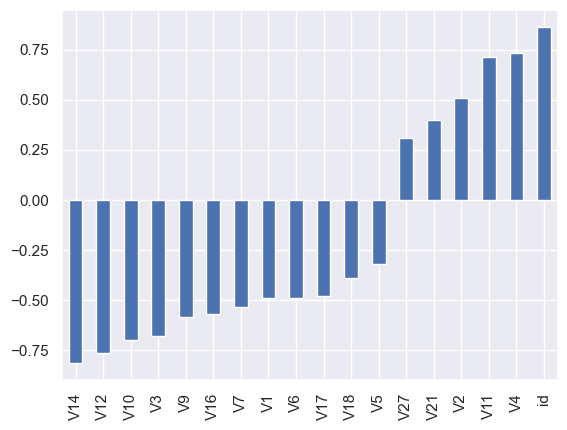

In [24]:
data.corr()['Class'][:-1].sort_values().plot(kind = 'bar'); #Dropping class correlated with itself

In [25]:
#Shuffling data

data = data.sample(frac = 1)

In [26]:
#Separating target from features

y = data.Class
X = data.drop(columns = ['Class'], axis =1)

In [27]:
#Reseting indices of X and y

X_reset = X.reset_index(drop = True)
y_reset = y.reset_index(drop = True)

In [28]:
#Instantiating standard scaler

scaler = StandardScaler()

# 3. Dimensionality reduction

3.1. Linear Discriminant Analysis

In [29]:
#Deriving the LDA model

lda = LinearDiscriminantAnalysis(solver = 'eigen', n_components = 1, shrinkage = 'auto') 
#1 component, because there are only 2 classes (0 and 1)

X_lda = lda.fit_transform(X_reset, y_reset)

data1D = pd.DataFrame(data = X_lda, columns = ['Dimension'])
data1D['Class'] = y_reset

data1D.dropna(axis = 0, inplace = True)
data1D.head()

Dimension  Class
0   6.023759      1
1   4.016507      1
2   5.262851      1
3   3.728946      1
4   0.713552      0

In [30]:
data1D.Class.value_counts()

0    28139
1    25881
Name: Class, dtype: int64

In [31]:
data1D.corr()['Class']

Dimension    0.932431
Class        1.000000
Name: Class, dtype: float64

In [32]:
lda.explained_variance_ratio_ #1 dimension from LDA explains almost all of total data variance

array([1.00004733])

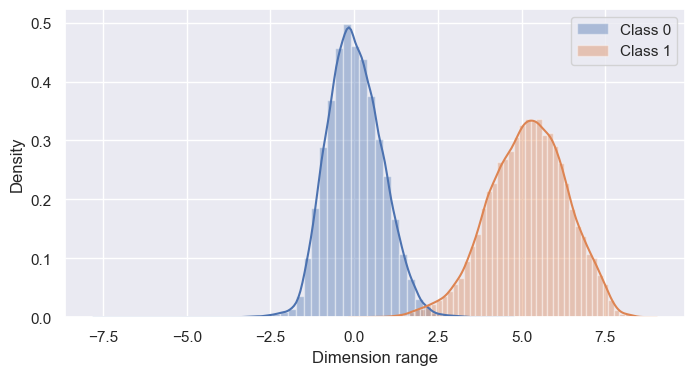

In [33]:
#Plotting dimension distribution with respect to classes

plt.figure(figsize=(8, 4))

sns.distplot(data1D.query('Class == 0').Dimension, label = 'Class 0', kde = True)
sns.distplot(data1D.query('Class == 1').Dimension, label = 'Class 1', kde = True)
plt.xlabel('Dimension range')
plt.legend();

INSIGHT :

The dimension extrapolated by LDA camptures almost all variance of input features and is very strongly correlated with target. That implies that this dimension may be a good predictor for classification.

In [34]:
#Preparing model data after dimensionality reduction

y_lda = data1D.Class
X_lda = data1D.drop(columns = ['Class'], axis = 1)

X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y_lda, test_size = 0.1, random_state = 42)

X_train_lda = scaler.fit_transform(X_train_lda)
X_test_lda = scaler.transform(X_test_lda)

3.2. Principal Component Analysis

In [35]:
#Befor applying PCA, features must be standardized

X_standardized = StandardScaler().fit_transform(X_reset)

In [36]:
#Deriving the PCA model

pca = PCA(n_components = 2, random_state = 42)

X_pca = pca.fit_transform(X_standardized)

data2D = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
data2D['Class'] = y_reset

data2D.dropna(axis = 0, inplace = True)
data2D.head()

PC1       PC2  Class
0  4.094351 -0.687262      1
1  2.558896 -0.319465      1
2  4.532306 -0.876859      1
3 -1.829699  2.609863      1
4 -2.766427  0.140382      0

In [37]:
data2D.Class.value_counts()

0    28139
1    25881
Name: Class, dtype: int64

In [38]:
data2D.corr()['Class']

PC1      0.771677
PC2      0.386660
Class    1.000000
Name: Class, dtype: float64

In [39]:
pca.explained_variance_ratio_ #2 TOP PC explains 2/3 of total data variance

array([0.56979287, 0.08045619], dtype=float32)

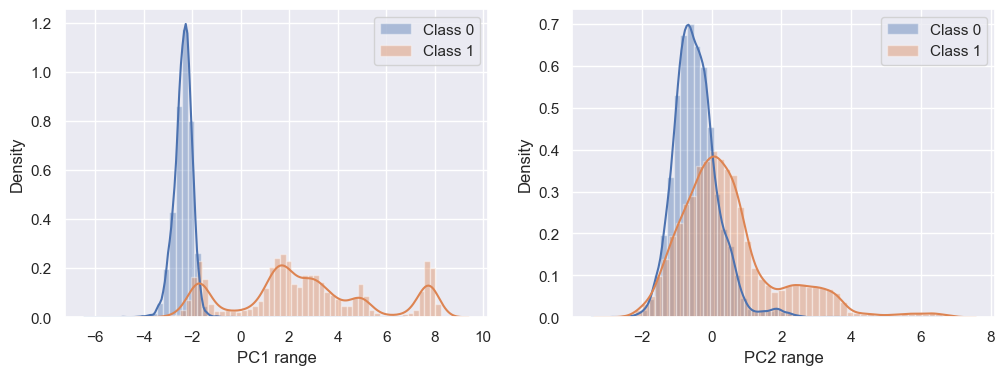

In [40]:
#Plotting top 2 principal components' distribution with respect to classes

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.distplot(data2D.query('Class == 0').PC1, label = 'Class 0', kde = True)
sns.distplot(data2D.query('Class == 1').PC1, label = 'Class 1', kde = True)
plt.xlabel('PC1 range')
plt.legend()

plt.subplot(1, 2, 2)
sns.distplot(data2D.query('Class == 0').PC2, label = 'Class 0', kde = True)
sns.distplot(data2D.query('Class == 1').PC2, label = 'Class 1', kde = True)
plt.xlabel('PC2 range')
plt.legend()

plt.show()

INSIGHT :

First principal component shows ranges where particular classes are most likely to appear and there is a relatively small area where classes overlap. Second principal component is not that precise, yet gives some additional information that may help to set boundaries between the classes.

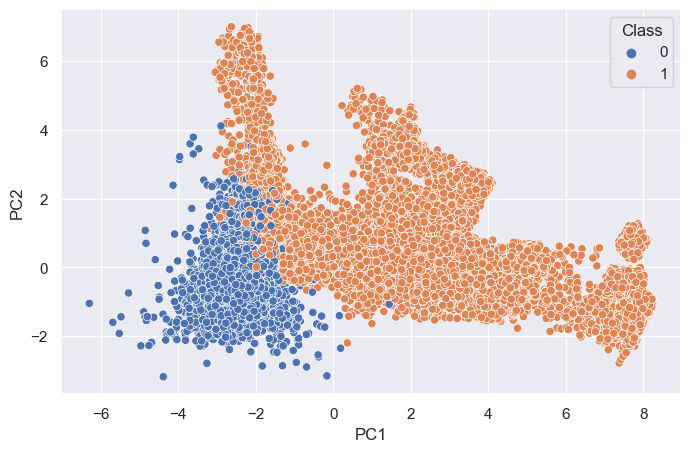

In [41]:
#Plotting data with reduced dimensionality - experimenting with 'Class' groupping

plt.figure(figsize = (8, 5))
sns.scatterplot(x = 'PC1', y = 'PC2', hue = 'Class', data = data2D)
plt.show();

INSIGHT : 

PC1 seems to be a very good predictor for the analyzed classification issue, due to very different distributions that intersect slightly in a short range with reletively distinct probabilies associated with that range.

PC2 could be considered as an auxiliary predictor; despite the fact that larger part of distributions cover the similar area, yet there are parts that distinguishes classes very well.

In [42]:
#Preparing model data after dimensionality reduction

y_pca = data2D.Class
X_pca = data2D.drop(columns = ['Class'], axis = 1)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size = 0.1, random_state = 42)

X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

3.3. t-Distributed Stochastic Neighbour Embedding

In [43]:
#Deriving the t-DSNE model

tsne = TSNE(n_components = 3, random_state = 42, early_exaggeration = 8, n_iter = 250)

X_tsne = tsne.fit_transform(X_reset)

data3D = pd.DataFrame(data = X_tsne, columns = ['Dim1', 'Dim2', 'Dim3'])
data3D['Class'] = y_reset

data3D.dropna(axis = 0, inplace = True)
data3D.head()

Dim1      Dim2      Dim3  Class
0  7.713368 -2.260127  5.398010      1
1  1.894650 -0.087019  5.553206      1
2  3.105472 -2.651952  3.491265      1
3  2.525492  8.849276 -0.583836      1
4 -4.198383  7.557756  4.931735      0

In [44]:
data3D.Class.value_counts()

0    28139
1    25881
Name: Class, dtype: int64

In [45]:
data3D.corr()['Class']

Dim1     0.813953
Dim2     0.109468
Dim3     0.019819
Class    1.000000
Name: Class, dtype: float64

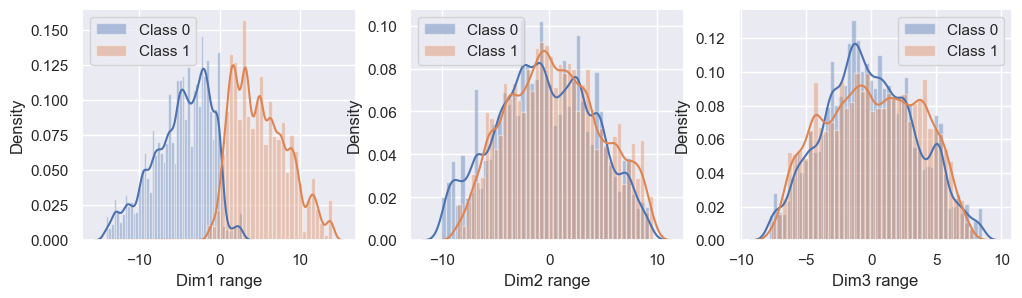

In [46]:
#Plotting 3 dimensions' distribution with respect to classes

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
sns.distplot(data3D.query('Class == 0').Dim1, label = 'Class 0', kde = True)
sns.distplot(data3D.query('Class == 1').Dim1, label = 'Class 1', kde = True)
plt.xlabel('Dim1 range')
plt.legend()

plt.subplot(1, 3, 2)
sns.distplot(data3D.query('Class == 0').Dim2, label = 'Class 0', kde = True)
sns.distplot(data3D.query('Class == 1').Dim2, label = 'Class 1', kde = True)
plt.xlabel('Dim2 range')
plt.legend()

plt.subplot(1, 3, 3)
sns.distplot(data3D.query('Class == 0').Dim3, label = 'Class 0', kde = True)
sns.distplot(data3D.query('Class == 1').Dim3, label = 'Class 1', kde = True)
plt.xlabel('Dim3 range')
plt.legend()

plt.show();

INSIGHT :

Combination of such distributed dimensions may be effective to seperate classes, if non-linear models were given a try.

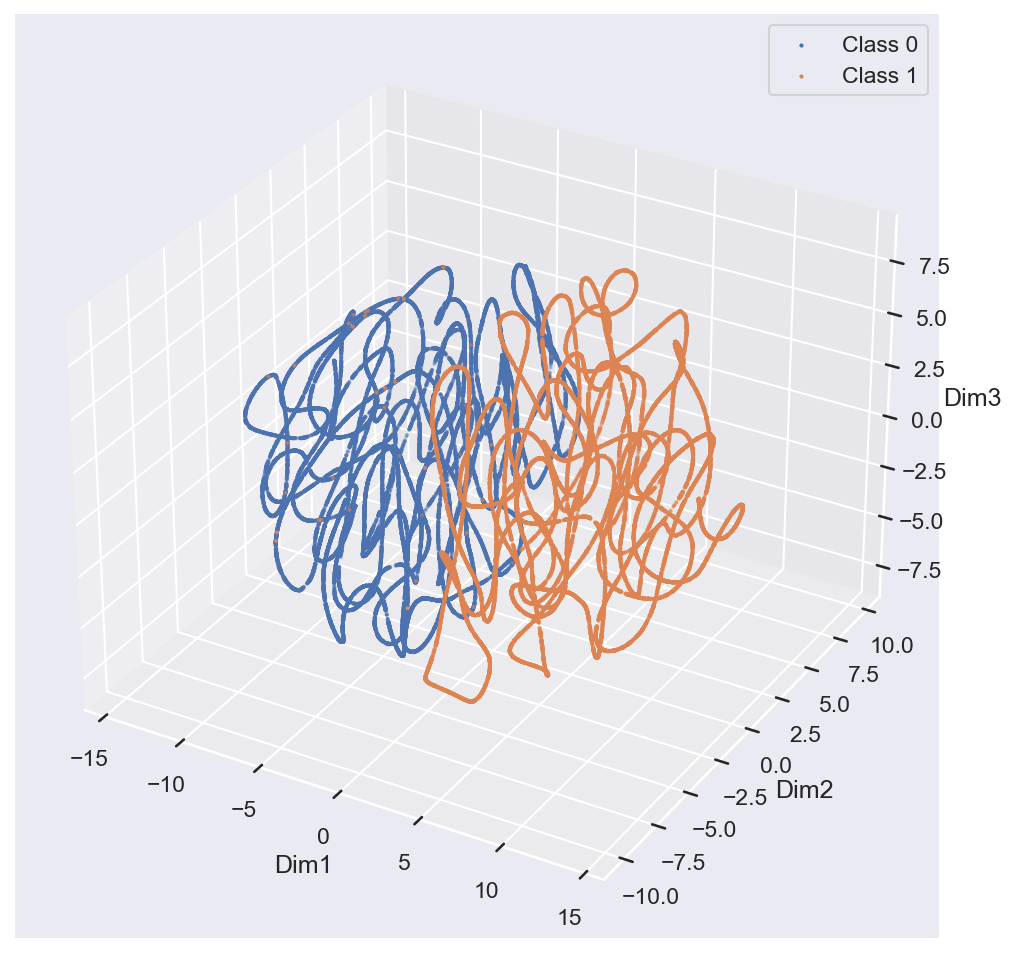

In [47]:
#Plotting data with reduced dimensionality - experimenting with 'Class' groupping

fig = plt.figure(figsize=(14, 8), dpi = 150)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data3D.query('Class == 0')['Dim1'], 
           data3D.query('Class == 0')['Dim2'], 
           data3D.query('Class == 0')['Dim3'], 
           label = 'Class 0', s = 1, marker='o')

ax.scatter(data3D.query('Class == 1')['Dim1'], 
           data3D.query('Class == 1')['Dim2'], 
           data3D.query('Class == 1')['Dim3'], 
           label = 'Class 1', s = 1, marker='o')

ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.set_zlabel('Dim3')
ax.legend()

plt.show();

In [48]:
#Preparing model data after dimensionality reduction

y_tdsne = data3D.Class
X_tdsne = data3D.drop(columns = ['Class'], axis = 1)

X_train_tdsne, X_test_tdsne, y_train_tdsne, y_test_tdsne = train_test_split(X_tdsne, y_tdsne, test_size = 0.1, random_state = 42)

X_train_tdsne = scaler.fit_transform(X_train_tdsne)
X_test_tdsne = scaler.transform(X_test_tdsne)

# 4. Machine Learning Models

NOTE : Project considers fraudalent operation using credit card, so it assumed that a priority in designing classification model is to minimize the number of false negatives (we want as minimal outcomes as possible where prediction will point safe operation (0), while in fact it is fraudulent (1)). Therefore, the most suitable metric would be RECALL (as maximized as possible). 

4.1. Random Forest

In [49]:
#Defining model hyperparameters' optimization procedure for Random Forest

def forest_tuning(X, y, n_trials) :
    
    def objective(trial):
    
        #Defining the search space for hyperparameters
        
        n_estimators = trial.suggest_int("n_estimators", 10, 200)
        max_depth = trial.suggest_int("max_depth", 2, 32)
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
        max_features = trial.suggest_categorical("max_features", [None, "sqrt", "log2"])
        #max_features = trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"])
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

        #Creating a Random Forest classifier with the suggested hyperparameters
        
        rf = RandomForestClassifier(
             n_estimators = n_estimators,
             max_depth = max_depth,
             min_samples_split = min_samples_split,
             min_samples_leaf = min_samples_leaf,
             max_features = max_features,
             criterion = criterion,
             random_state = 42
        )

        #Calculating recall using cross-validation
        
        recalls = cross_val_score(rf, X, y, cv = 3, n_jobs = -1, scoring = make_scorer(recall_score))
        mean_recall = recalls.mean()

        return mean_recall
    
    #Creating an Optuna study and run the optimization process

    sampler = optuna.samplers.TPESampler(seed = 42)
    study = optuna.create_study(direction = "maximize", sampler = sampler)
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)
    
    best_params = study.best_params
    best_recall = study.best_value
    
    return best_params, best_recall

In [50]:
#1D input data - hyperparameter tuning

best_params_lda, best_recall_lda = forest_tuning(X_train_lda, y_train_lda, 100)

[I 2024-06-24 13:52:30,397] A new study created in memory with name: no-name-3bc4370b-21e1-49b5-a6f5-5cf55e60fa23


  0%|          | 0/100 [00:00<?, ?it/s]

In [51]:
#Creating a Random Forest classifier with the best hyperparameters

model_rf_lda_tuned = RandomForestClassifier(**best_params_lda, random_state = 42)
model_rf_lda_tuned.fit(X_train_lda, y_train_lda)

y_pred_rf_lda_tuned = model_rf_lda_tuned.predict(X_test_lda)

recall_lda = recall_score(y_test_lda, y_pred_rf_lda_tuned)
print("Test Recall with Best Hyperparameters:", recall_lda)

Test Recall with Best Hyperparameters: 0.9914396887159533


In [52]:
#Generating a classification report

print(classification_report(y_test_lda, y_pred_rf_lda_tuned))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2832
           1       1.00      0.99      0.99      2570

    accuracy                           0.99      5402
   macro avg       0.99      0.99      0.99      5402
weighted avg       0.99      0.99      0.99      5402



In [53]:
#2D input data - hyperparameter tuning

best_params_pca, best_recall_pca = forest_tuning(X_train_pca, y_train_pca, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [54]:
#Creating a Random Forest classifier with the best hyperparameters

model_rf_pca_tuned = RandomForestClassifier(**best_params_pca, random_state = 42)
model_rf_pca_tuned.fit(X_train_pca, y_train_pca)

y_pred_rf_pca_tuned = model_rf_pca_tuned.predict(X_test_pca)

recall_pca = recall_score(y_test_pca, y_pred_rf_pca_tuned)
print("Test Recall with Best Hyperparameters:", recall_pca)

Test Recall with Best Hyperparameters: 0.966147859922179


In [55]:
#Generating a classification report

print(classification_report(y_test_pca, y_pred_rf_pca_tuned))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2832
           1       0.98      0.97      0.97      2570

    accuracy                           0.97      5402
   macro avg       0.97      0.97      0.97      5402
weighted avg       0.97      0.97      0.97      5402



In [56]:
#3D input data - hyperparameter tuning

best_params_tdsne, best_recall_tdsne = forest_tuning(X_train_tdsne, y_train_tdsne, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [57]:
#Creating a Random Forest classifier with the best hyperparameters

model_rf_tdsne_tuned = RandomForestClassifier(**best_params_tdsne, random_state = 42)
model_rf_tdsne_tuned.fit(X_train_tdsne, y_train_tdsne)

y_pred_rf_tdsne_tuned = model_rf_tdsne_tuned.predict(X_test_tdsne)

recall_tdsne = recall_score(y_test_tdsne, y_pred_rf_tdsne_tuned)
print("Test Recall with Best Hyperparameters:", recall_tdsne)

Test Recall with Best Hyperparameters: 0.998443579766537


In [58]:
#Generating a classification report

print(classification_report(y_test_tdsne, y_pred_rf_tdsne_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      2570

    accuracy                           1.00      5402
   macro avg       1.00      1.00      1.00      5402
weighted avg       1.00      1.00      1.00      5402



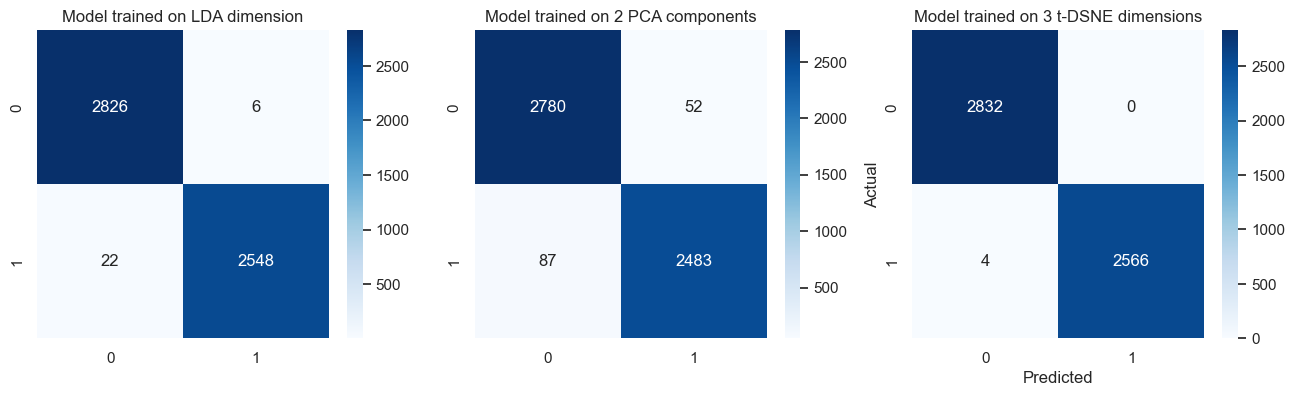

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi = 100)

confusion_matrix_axis(y_test_lda, y_pred_rf_lda_tuned, axes[0], 'Model trained on LDA dimension')
confusion_matrix_axis(y_test_pca, y_pred_rf_pca_tuned, axes[1], 'Model trained on 2 PCA components')
confusion_matrix_axis(y_test_tdsne, y_pred_rf_tdsne_tuned, axes[2], 'Model trained on 3 t-DSNE dimensions')

4.2. XGBoost

In [60]:
#Defining model hyperparameters' optimization procedure for XGBoost

def xgboost_tuning(X, y, n_trials) :
    
    def objective(trial):
        #Defining the search space for hyperparameters
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 3, 20),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
            "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "random_state": 42,
            "use_label_encoder": False,  # Disable warnings
        }

        #Creating an XGBoost classifier with the suggested hyperparameters
        model = xgb.XGBClassifier(**params)

        #Calculating recall using cross-validation
        recalls = cross_val_score(model, X, y, cv = 3, n_jobs =- 1, scoring=make_scorer(recall_score))
        mean_recall = recalls.mean()

        return mean_recall
    
    #Creating an Optuna study and run the optimization process

    sampler = optuna.samplers.TPESampler(seed = 42)   
    study = optuna.create_study(direction = "maximize", sampler = sampler)   
    optuna.logging.set_verbosity(optuna.logging.WARNING)  
    study.optimize(objective, n_trials = n_trials, n_jobs = -1, show_progress_bar = True)
    
    best_params = study.best_params
    best_recall = study.best_value
    
    return best_params, best_recall

In [61]:
#1D input data - hyperparameter tuning

best_params_lda, best_recall_lda = xgboost_tuning(X_train_lda, y_train_lda, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
#Creating a XGBoost classifier with the best hyperparameters

model_xgb_lda_tuned = xgb.XGBClassifier(**best_params_lda, random_state = 42)
model_xgb_lda_tuned.fit(X_train_lda, y_train_lda)

y_pred_xgb_lda_tuned = model_xgb_lda_tuned.predict(X_test_lda)

recall_lda = recall_score(y_test_lda, y_pred_xgb_lda_tuned)
print("Test Recall with Best Hyperparameters:", recall_lda)

Test Recall with Best Hyperparameters: 0.9914396887159533


In [63]:
print(classification_report(y_test_lda, y_pred_xgb_lda_tuned))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2832
           1       1.00      0.99      0.99      2570

    accuracy                           0.99      5402
   macro avg       0.99      0.99      0.99      5402
weighted avg       0.99      0.99      0.99      5402



In [64]:
#2D input data - hyperparameter tuning

best_params_pca, best_recall_pca = xgboost_tuning(X_train_pca, y_train_pca, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
#Creating a XGBoost classifier with the best hyperparameters

model_xgb_pca_tuned = xgb.XGBClassifier(**best_params_pca, random_state = 42)
model_xgb_pca_tuned.fit(X_train_pca, y_train_pca)

y_pred_xgb_pca_tuned = model_xgb_pca_tuned.predict(X_test_pca)

recall_pca = recall_score(y_test_pca, y_pred_xgb_pca_tuned)
print("Test Recall with Best Hyperparameters:", recall_pca)

Test Recall with Best Hyperparameters: 0.9669260700389105


In [66]:
print(classification_report(y_test_pca, y_pred_xgb_pca_tuned))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2832
           1       0.98      0.97      0.97      2570

    accuracy                           0.97      5402
   macro avg       0.97      0.97      0.97      5402
weighted avg       0.97      0.97      0.97      5402



In [67]:
#3D input data - hyperparameter tuning

best_params_tdsne, best_recall_tdsne = xgboost_tuning(X_train_tdsne, y_train_tdsne, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
#Creating a XGBoost classifier with the best hyperparameters

model_xgb_tdsne_tuned = xgb.XGBClassifier(**best_params_tdsne, random_state = 42)
model_xgb_tdsne_tuned.fit(X_train_tdsne, y_train_tdsne)

y_pred_xgb_tdsne_tuned = model_xgb_tdsne_tuned.predict(X_test_tdsne)

recall_tdsne = recall_score(y_test_tdsne, y_pred_xgb_tdsne_tuned)
print("Test Recall with Best Hyperparameters:", recall_tdsne)

Test Recall with Best Hyperparameters: 0.998443579766537


In [69]:
print(classification_report(y_test_tdsne, y_pred_xgb_tdsne_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      2570

    accuracy                           1.00      5402
   macro avg       1.00      1.00      1.00      5402
weighted avg       1.00      1.00      1.00      5402



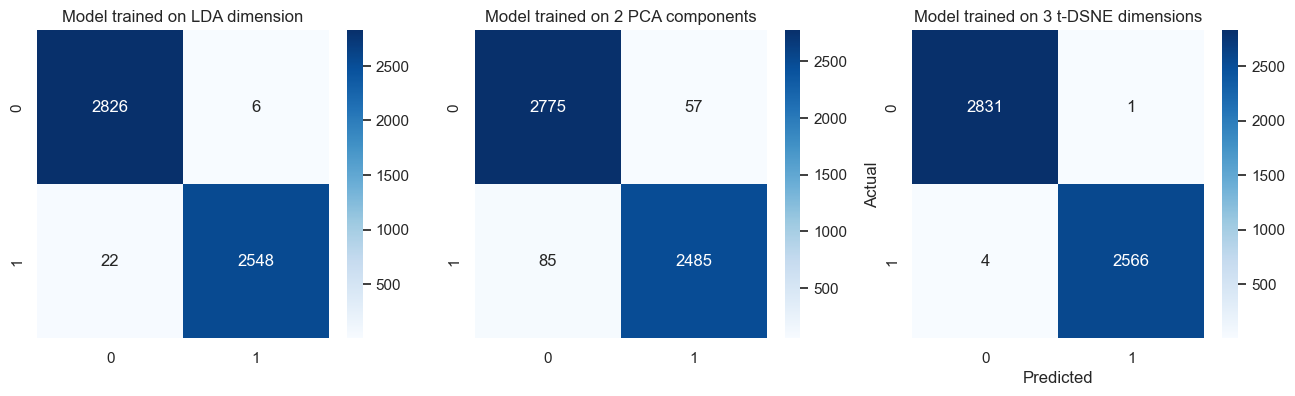

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi = 100)

confusion_matrix_axis(y_test_lda, y_pred_xgb_lda_tuned, axes[0], 'Model trained on LDA dimension')
confusion_matrix_axis(y_test_pca, y_pred_xgb_pca_tuned, axes[1], 'Model trained on 2 PCA components')
confusion_matrix_axis(y_test_tdsne, y_pred_xgb_tdsne_tuned, axes[2], 'Model trained on 3 t-DSNE dimensions')

# 5. Deep Learning Models

5.1. Sequential API Neural Networks

In [76]:
early_stopping = EarlyStopping(monitor = 'val_loss',  mode = 'min', verbose = 1, patience = 10, restore_best_weights = True)

5.1.1. LDA transformation input - 1D array as a predictions input

In [132]:
checkpoint_lda = ModelCheckpoint('best_model_lda.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')

model_lda = Sequential()

model_lda.add(Dense(8, input_dim = 1, activation = 'relu'))
model_lda.add(Dropout(0.5))

#model_lda.add(Dense(8, activation='relu'))
#.add(Dropout(0.5))

model_lda.add(Dense(1, activation = 'sigmoid'))

model_lda.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = [tf.keras.metrics.Recall()])

In [133]:
history_lda = model_lda.fit(X_train_lda, y_train_lda, 
                            epochs = 50, 
                            batch_size = 32, 
                            validation_split = 0.2, 
                            callbacks = [early_stopping, checkpoint_lda])

Epoch 1/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.3970 - recall_12: 0.7227 - val_loss: 0.1006 - val_recall_12: 0.9811
Epoch 2/50
1216/1216 [==============================] - 1s 1ms/step - loss: 0.2728 - recall_12: 0.9774 - val_loss: 0.0515 - val_recall_12: 0.9854
Epoch 3/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.2628 - recall_12: 0.9855 - val_loss: 0.0393 - val_recall_12: 0.9861
Epoch 4/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.2586 - recall_12: 0.9882 - val_loss: 0.0336 - val_recall_12: 0.9871
Epoch 5/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.2600 - recall_12: 0.9898 - val_loss: 0.0304 - val_recall_12: 0.9891
Epoch 6/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.2560 - recall_12: 0.9913 - val_loss: 0.0292 - val_recall_12: 0.9891
Epoch 7/50
1216/1216 [==============================] - 1s 1ms/step - loss: 0.2544 - recall_12: 0.9913 - val_loss: 0.0283 - 

In [135]:
#Making predictions on the test data and generating report

y_pred_lda = model_lda.predict(X_test_lda)
y_pred_labels_lda = (y_pred_lda > 0.5).astype(int)

print(classification_report(y_test_lda, y_pred_labels_lda))

169/169 [==============================] - 0s 687us/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2832
           1       1.00      0.99      0.99      2570

    accuracy                           1.00      5402
   macro avg       1.00      0.99      0.99      5402
weighted avg       1.00      1.00      1.00      5402



5.1.2. PCA transformation input - 2D array as a predictions input

In [136]:
checkpoint_pca = ModelCheckpoint('best_model_pca.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')

model_pca = Sequential()

model_pca.add(Dense(16, input_dim = 2, activation = 'relu'))
#model_pca.add(Dropout(0.5))

model_pca.add(Dense(8, activation='relu'))
model_pca.add(Dropout(0.5))

model_pca.add(Dense(1, activation = 'sigmoid'))

model_pca.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = [tf.keras.metrics.Recall()])

In [137]:
history_pca = model_pca.fit(X_train_pca, y_train_pca, 
                            epochs = 50, 
                            batch_size = 32, 
                            validation_split = 0.2, 
                            callbacks = [early_stopping, checkpoint_pca])

Epoch 1/50
1216/1216 [==============================] - 3s 2ms/step - loss: 0.2500 - recall_13: 0.8912 - val_loss: 0.0826 - val_recall_13: 0.9610
Epoch 2/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1545 - recall_13: 0.9148 - val_loss: 0.0743 - val_recall_13: 0.9691
Epoch 3/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1430 - recall_13: 0.9647 - val_loss: 0.0731 - val_recall_13: 0.9644
Epoch 4/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1384 - recall_13: 0.9656 - val_loss: 0.0721 - val_recall_13: 0.9631
Epoch 5/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1357 - recall_13: 0.9663 - val_loss: 0.0710 - val_recall_13: 0.9631
Epoch 6/50
1216/1216 [==============================] - 1s 1ms/step - loss: 0.1344 - recall_13: 0.9674 - val_loss: 0.0728 - val_recall_13: 0.9586
Epoch 7/50
1216/1216 [==============================] - 1s 1ms/step - loss: 0.1346 - recall_13: 0.9675 - val_loss: 0.0711 - 

In [139]:
#Making predictions on the test data and generating report

y_pred_pca = model_pca.predict(X_test_pca)
y_pred_labels_pca = (y_pred_pca > 0.5).astype(int)

print(classification_report(y_test_pca, y_pred_labels_pca))

169/169 [==============================] - 0s 710us/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2832
           1       0.98      0.97      0.97      2570

    accuracy                           0.98      5402
   macro avg       0.98      0.98      0.98      5402
weighted avg       0.98      0.98      0.98      5402



5.1.3. t-DSNE transformation input - 3D array as a predictions input

In [140]:
checkpoint_tdsne = ModelCheckpoint('best_model_tdsne.h5', monitor = 'val_loss', save_best_only = True, mode = 'min')

model_tdsne = Sequential()

model_tdsne.add(Dense(16, input_dim = 3, activation = 'relu'))
model_pca.add(Dropout(0.5))

model_tdsne.add(Dense(8, activation='relu'))
model_tdsne.add(Dropout(0.5))

model_tdsne.add(Dense(8, activation='relu'))
model_tdsne.add(Dropout(0.5))

model_tdsne.add(Dense(1, activation = 'sigmoid'))

model_tdsne.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = [tf.keras.metrics.Recall()])

In [141]:
history_tdsne = model_tdsne.fit(X_train_tdsne, y_train_tdsne, 
                            epochs = 50, 
                            batch_size = 32, 
                            validation_split = 0.2, 
                            callbacks = [early_stopping, checkpoint_tdsne])

Epoch 1/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.3473 - recall_14: 0.7774 - val_loss: 0.0501 - val_recall_14: 0.9758
Epoch 2/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1631 - recall_14: 0.8954 - val_loss: 0.0439 - val_recall_14: 0.9676
Epoch 3/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1309 - recall_14: 0.9025 - val_loss: 0.0339 - val_recall_14: 0.9771
Epoch 4/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.1130 - recall_14: 0.9221 - val_loss: 0.0278 - val_recall_14: 0.9882
Epoch 5/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1064 - recall_14: 0.9283 - val_loss: 0.0245 - val_recall_14: 0.9923
Epoch 6/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.1051 - recall_14: 0.9282 - val_loss: 0.0204 - val_recall_14: 0.9884
Epoch 7/50
1216/1216 [==============================] - 2s 1ms/step - loss: 0.0992 - recall_14: 0.9316 - val_loss: 0.0195 - 

In [143]:
#Making predictions on the test data and generating report

y_pred_tdsne = model_tdsne.predict(X_test_tdsne)
y_pred_labels_tdsne = (y_pred_tdsne > 0.5).astype(int)

print(classification_report(y_test_tdsne, y_pred_labels_tdsne))

169/169 [==============================] - 0s 710us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      0.99      1.00      2570

    accuracy                           1.00      5402
   macro avg       1.00      1.00      1.00      5402
weighted avg       1.00      1.00      1.00      5402



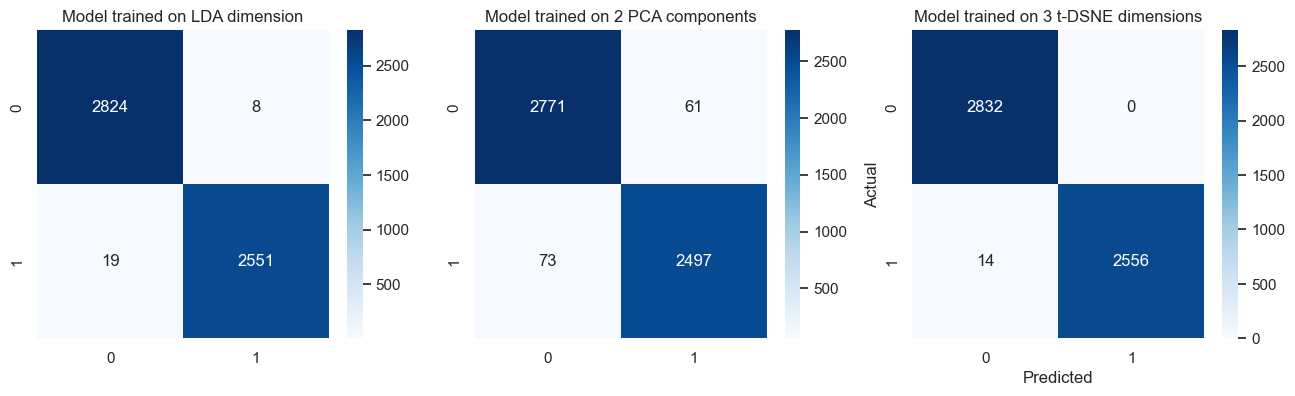

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi = 100)

confusion_matrix_axis(y_test_lda, y_pred_labels_lda, axes[0], 'Model trained on LDA dimension')
confusion_matrix_axis(y_test_pca, y_pred_labels_pca, axes[1], 'Model trained on 2 PCA components')
confusion_matrix_axis(y_test_tdsne, y_pred_labels_tdsne, axes[2], 'Model trained on 3 t-DSNE dimensions')

INSIGHT : 

Let's combine those 3 approaches into one and experiment with functional API neurat networks. Will a combined approach return a model with better performance?

5.2. Functional API Neural Network

NOTE : 

The network will be constructed using three inputs :
- 1D data from LDA
- 2D data from PCA
- 3D data from t-DSNE.

The logic behind this architecture is to combine a linear approach (LDA, PCA) with a non-linear one (t-DSNE) and see how it will affect the quality of predictions.

In [145]:
#Loading the best models

best_model_lda = load_model('best_model_lda.h5')
best_model_pca = load_model('best_model_pca.h5')
best_model_tdsne = load_model('best_model_tdsne.h5')

In [147]:
#Defining inputs for each subset of features

input_lda = Input(shape=(1,))
input_pca = Input(shape=(2,))
input_tdsne = Input(shape=(3,))

In [148]:
#Getting the output of each pretrained model

output_lda = best_model_lda(input_lda)
output_pca = best_model_pca(input_pca)
output_tdsne = best_model_tdsne(input_tdsne)

In [149]:
#Concatenating the outputs
combined = Concatenate()([output_lda, output_pca, output_tdsne])

#Adding a new output layer (or more layers if needed)
combined_output = Dense(1, activation = 'sigmoid')(combined)

#Creating the combined model
combined_model = Model(inputs = [input_lda, input_pca, input_tdsne], outputs = combined_output)
combined_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 sequential_13 (Sequential)     (None, 1)            25          ['input_4[0][0]']                
                                                                                              

In [151]:
#Training the combined model on the combined input sets

history_combined = combined_model.fit([X_train_lda, X_train_pca, X_train_tdsne], y_train_lda, 
                                      epochs = 50, batch_size = 32, validation_split = 0.2,
                                      callbacks=[early_stopping])

Epoch 1/50
1216/1216 [==============================] - 4s 2ms/step - loss: 0.3592 - accuracy: 0.8991 - val_loss: 0.1949 - val_accuracy: 0.9947
Epoch 2/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.1826 - accuracy: 0.9903 - val_loss: 0.0994 - val_accuracy: 0.9983
Epoch 3/50
1216/1216 [==============================] - 3s 2ms/step - loss: 0.1096 - accuracy: 0.9926 - val_loss: 0.0568 - val_accuracy: 0.9983
Epoch 4/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0726 - accuracy: 0.9933 - val_loss: 0.0346 - val_accuracy: 0.9990
Epoch 5/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0512 - accuracy: 0.9943 - val_loss: 0.0227 - val_accuracy: 0.9992
Epoch 6/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0390 - accuracy: 0.9949 - val_loss: 0.0162 - val_accuracy: 0.9990
Epoch 7/50
1216/1216 [==============================] - 2s 2ms/step - loss: 0.0341 - accuracy: 0.9934 - val_loss: 0.0121 - val_accuracy:

In [153]:
#Making predictions on the test data and generating report

y_pred_combined = combined_model.predict([X_test_lda, X_test_pca, X_test_tdsne])
y_pred_combined_labels = (y_pred_combined > 0.5).astype(int)

print(classification_report(y_test_tdsne, y_pred_combined_labels))

169/169 [==============================] - 0s 826us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2832
           1       1.00      1.00      1.00      2570

    accuracy                           1.00      5402
   macro avg       1.00      1.00      1.00      5402
weighted avg       1.00      1.00      1.00      5402



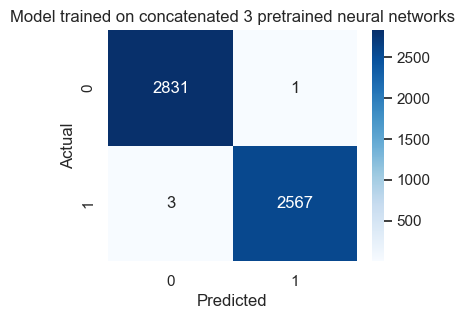

In [154]:
#Plotting confusion matrix

plt.figure(figsize=(4, 3), dpi = 100)
sns.heatmap(confusion_matrix(y_test_tdsne, y_pred_combined_labels), annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Model trained on concatenated 3 pretrained neural networks')
plt.show()

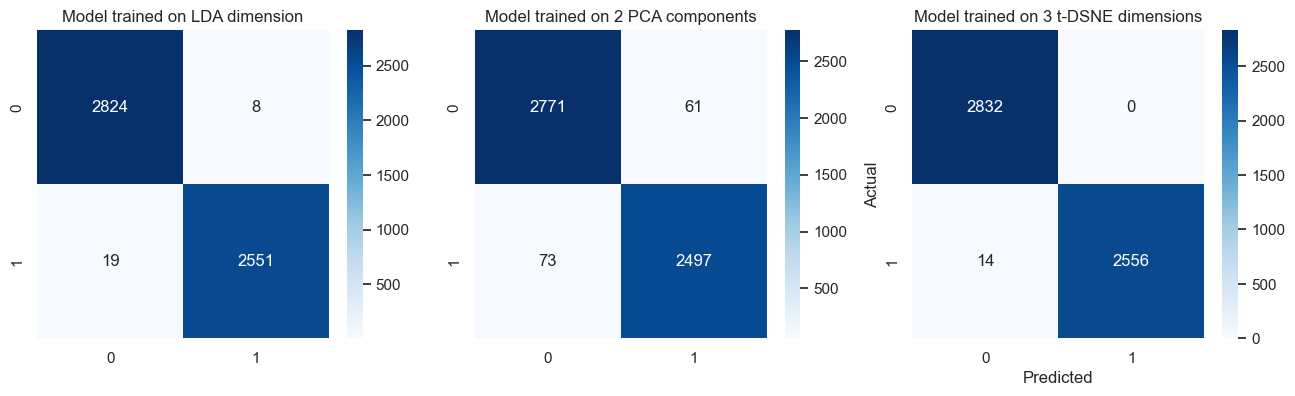

In [155]:
#Confusion matrixes of input neural networks - for comparison

fig, axes = plt.subplots(1, 3, figsize=(16, 4), dpi = 100)

confusion_matrix_axis(y_test_lda, y_pred_labels_lda, axes[0], 'Model trained on LDA dimension')
confusion_matrix_axis(y_test_pca, y_pred_labels_pca, axes[1], 'Model trained on 2 PCA components')
confusion_matrix_axis(y_test_tdsne, y_pred_labels_tdsne, axes[2], 'Model trained on 3 t-DSNE dimensions')

# Summary

Classical algorithms proved that after significant dimensionality reduction models can still obtain with relatively good performance. Note that models trained on linear transformations (LDA, PCA) resulted with bigger ratio of false positives, what implies that the 'linear' aproach lost some information that could help to determine better fraudulent operations. On the other hand, both random forest and xgboost models fed with non-linearly transformed data inflicted relatively low fractions of both fals positives and false negatives.

On the other hand, training independently 3 sequential neural networks on different representation of features and next combining them into 1 functional API neural network resulted with a very powerful prediction tool.